In [4]:
import numpy as np
import tifffile as tiff
import os
from tqdm import tqdm  # optional, for progress bar

# Folder where images are stored
folder_path = r'J:\Akshat\raw'

# Get sorted list of all .tif files
tif_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.tif')])

# Image dimensions
num_images = len(tif_files)  # should be 4477
img_height = 2850
img_width = 2850

# Preallocate memory for the 3D projection volume
projection_volume = np.zeros((num_images, img_height, img_width), dtype=np.float16)

# Load images
for i, fname in enumerate(tqdm(tif_files, desc="Loading projections")):
    img_path = os.path.join(folder_path, fname)
    projection_volume[i] = tiff.imread(img_path).astype(np.float16)

# Save to disk if needed
np.save(r'J:\Akshat\projection_volume.npy', projection_volume)

print("Done. Shape of stacked projections:", projection_volume.shape)

Loading projections: 100%|█████████████████████████████████████████████████████████| 4477/4477 [12:53<00:00,  5.79it/s]


Done. Shape of stacked projections: (4477, 2850, 2850)


In [5]:
#to remove the last image which is the duplicate of the first image
projection_volume = projection_volume[:-1]

In [6]:
# Downsample by factor of 2 in both height and width
projection_volume_downsampled = projection_volume[::2, ::2, ::2]
print("New shape:", projection_volume_downsampled.shape)

New shape: (2238, 1425, 1425)


In [7]:
import astra
import numpy as np

# Constants
n_proj = 2238
det_rows = 1425
det_cols = 1425
pixel_size_mm = 0.15
sod = 20.184082
sdd = 855.551513671875

# Detector spacing in mm
det_spacing = (pixel_size_mm, pixel_size_mm)

# Projection angles (uniform over 360 degrees)
angles = np.linspace(0, 2 * np.pi, n_proj, endpoint=False)

# Create geometry dict
proj_geom = astra.create_proj_geom('cone', 
                                   det_spacing[0], det_spacing[1], 
                                   det_rows, det_cols, 
                                   angles, 
                                   sod, sdd - sod)

In [8]:
vol_size = 256  # or 256 for faster trial

vol_geom = astra.create_vol_geom(vol_size, vol_size, vol_size)

In [9]:
projection_volume_downsampled = np.transpose(projection_volume_downsampled, (1, 0, 2))

In [10]:
# Create 3D projection data object (on CPU)
proj_id = astra.data3d.create('-proj3d', proj_geom, projection_volume_downsampled)

# Create 3D volume object
rec_id = astra.data3d.create('-vol', vol_geom)

# Set up the SIRT3D_CUDA algorithm
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ProjectionDataId'] = proj_id
cfg['ReconstructionDataId'] = rec_id

alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 150)  # Number of SIRT iterations

reconstruction = astra.data3d.get(rec_id)

# Free GPU memory
astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)

In [28]:
print("Reconstruction shape:", reconstruction.shape)

Reconstruction shape: (256, 256, 256)


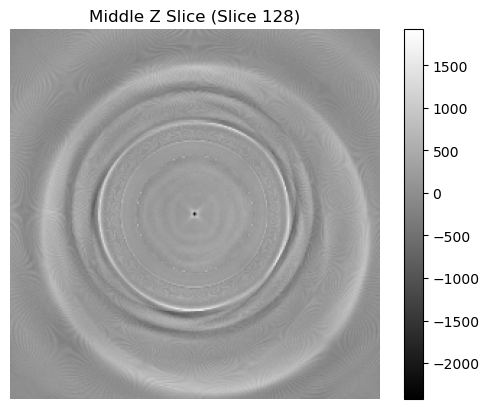

In [14]:
import matplotlib.pyplot as plt
import numpy as np


# Assuming 'reconstruction' is a 3D numpy array with shape (Z, Y, X)
# Take the middle slice along the Z axis
z_mid = reconstruction.shape[0] // 2
mid_slice = reconstruction[130, :, :]  # XY slice at middle Z

# Plot the slice
plt.imshow(mid_slice, cmap='gray')
plt.title(f'Middle Z Slice (Slice {z_mid})')
plt.axis('off')
plt.colorbar()
plt.show()

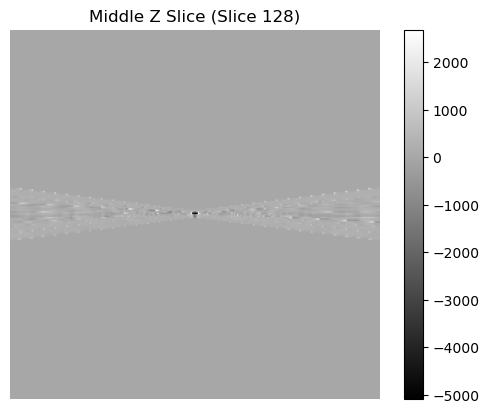

In [13]:
# Assuming 'reconstruction' is a 3D numpy array with shape (Z, Y, X)
# Take the middle slice along the X axis
x_mid = reconstruction.shape[1] // 2
mid_slice = reconstruction[:, :, x_mid]  # YZ slice at middle X

# Plot the slice
plt.imshow(mid_slice, cmap='gray')
plt.title(f'Middle Z Slice (Slice {x_mid})')
plt.axis('off')
plt.colorbar()
plt.show()

In [15]:
# Create geometry dict
proj_geom = astra.create_proj_geom('cone', 
                                   det_spacing[0], det_spacing[1], 
                                   det_rows, det_cols, 
                                   angles, 
                                   sod, sdd - sod)

In [16]:
vol_size = 256  # or 256 for faster trial

vol_geom = astra.create_vol_geom(vol_size, vol_size, vol_size)

In [ ]:
# Create 3D projection data object (on CPU)
proj_id = astra.data3d.create('-proj3d', proj_geom, projection_volume_downsampled)

# Create 3D volume object
rec_id = astra.data3d.create('-vol', vol_geom)

# Set up the SIRT3D_CUDA algorithm
cfg = astra.astra_dict('CGLS3D_CUDA')
cfg['ProjectionDataId'] = proj_id
cfg['ReconstructionDataId'] = rec_id

alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 150)  # Number of SIRT iterations

reconstruction = astra.data3d.get(rec_id)

# Free GPU memory
astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)